# Autoencoders for Anomaly Detection

Based on the article at https://bit.ly/2VgNyl7, made for the bonus task of the cyber data analytics class. Download the data and adjust the paths in the next cells.

Requires 
* seaborn
* tensorflow
* keras
* sklearn
* pyplot, pylab

and for visualizing the network also th4e graphviz package. Install directly from the notebook with **!pip install package**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

import numpy as np
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

SEED = 123 
DATA_SPLIT_PCT = 0.2

LABELS = ["Normal","Attack"]

# please adjust the dataset paths
NORMAL = 'data/BATADAL_dataset03.csv'
MIXED = 'data/BATADAL_dataset04.csv'

Using TensorFlow backend.


In [2]:
df_normal =  pd.read_csv(NORMAL, encoding="utf-8-sig", skipinitialspace=True)
df_mixed = pd.read_csv(MIXED, encoding="utf-8-sig", skipinitialspace=True)
df_normal.head()

,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
0,06/01/14 00,0.509730,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
1,06/01/14 01,0.412580,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0
2,06/01/14 02,0.320112,1.986093,4.140192,3.256733,3.574601,5.500000,2.246126,98.420959,1,...,91.056114,26.487364,86.582474,19.597170,83.988579,19.496712,72.425293,29.354538,28.454538,0
3,06/01/14 03,0.332879,2.009203,4.673478,3.744497,3.952379,5.500000,3.203573,97.575172,1,...,92.594353,26.575815,88.020546,26.028486,64.670486,25.922703,76.275040,29.449951,28.549952,0
4,06/01/14 04,0.483496,2.089049,5.237937,4.409456,3.504676,5.500000,4.439714,97.351059,1,...,94.473099,26.723457,90.422462,26.209970,64.746620,26.104692,76.703529,29.574265,28.674263,0


Harmonize the labels across the datasets to 0 / 1

**WARNING**: THIS TREATS *unlabeled* DATA AS NORMAL, see https://batadal.net/images/rules.pdf for the documentation of the -999 value.


In [3]:
df_mixed.ATT_FLAG.replace([-999, 1], [0, 1], inplace=True)

Drop non-numeric columns, concatenate the dataframes.
We train the autoencoder on the normal data from BATADAL_dataset03 and test on BATADAL_dataset04

In [4]:
df_normal = df_normal.drop(['DATETIME'], axis=1)
df_mixed = df_mixed.drop(['DATETIME'], axis=1)

df = pd.concat([df_normal, df_mixed], ignore_index=True)

Splitting into training, validation, testing, group into classes

In [5]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [6]:
df_train_0 = df_train.loc[df['ATT_FLAG'] == 0]
df_train_1 = df_train.loc[df['ATT_FLAG'] == 1]

df_train_0_x = df_train_0.drop(['ATT_FLAG'], axis=1)
df_train_1_x = df_train_1.drop(['ATT_FLAG'], axis=1)


df_valid_0 = df_valid.loc[df['ATT_FLAG'] == 0]
df_valid_1 = df_valid.loc[df['ATT_FLAG'] == 1]

df_valid_0_x = df_valid_0.drop(['ATT_FLAG'], axis=1)
df_valid_1_x = df_valid_1.drop(['ATT_FLAG'], axis=1)


df_test_0 = df_test.loc[df['ATT_FLAG'] == 0]
df_test_1 = df_test.loc[df['ATT_FLAG'] == 1]

df_test_0_x = df_test_0.drop(['ATT_FLAG'], axis=1)
df_test_1_x = df_test_1.drop(['ATT_FLAG'], axis=1)

Scale the data to 0-1 range

In [7]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['ATT_FLAG'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['ATT_FLAG'], axis = 1))

## Set up a neural network with relu-encoder

In [8]:
nb_epoch = 500
batch_size = 24
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 28
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
Colocations handled automatically by placer.


This requires pydot and graphviz installed

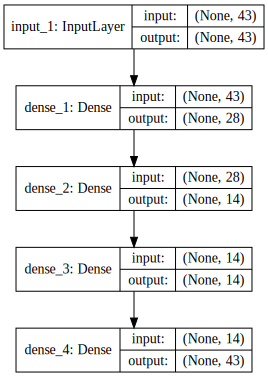

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## Train the network

In [10]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

earlyStopping= EarlyStopping(monitor='val_loss', patience=3, verbose=0,  min_delta=1e-4, mode='auto')
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, epsilon=1e-4, mode='min')

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb, earlyStopping,lr_reduced]).history

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.7/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 8143 samples, validate on 2030 samples
Epoch 1/500
8143/8143 [==============================] - 1s 130us/step - loss: 0.9224 - acc: 0.1733 - val_loss: 0.7385 - val_acc: 0.2296
Epoch 2/500
8143/8143 [==============================] - 1s 84us/step - loss: 0.7015 - acc: 0.2800 - val_loss: 0.6277 - val_acc: 0.3335
Epoch 3/500
8143/8143 [==============================] - 1s 79us/step - loss: 0.6219 - acc: 0.4108 - val_loss: 0.5937 - val_acc: 0.4433
Epoch 4/500
8143/8143 [==============================] - 1s 98us/step - loss: 0.5961 - acc: 0.4793 - val_loss: 0.5768 - val_acc: 0.4842
Epoch 5/500
8143/8143 [==============================] - 1s 103us/step - loss: 0.5797 - acc: 0.5058 - val_loss: 0.5662 - val_acc: 0.5350
Epoch 6/500
8143/8143 [==============================] - 1s 82us/step - loss: 0.5690 - acc: 0.5440 - val_loss: 0.5582 - val_acc: 0.5389
Epoch 7/500
8143/8143 [==============================] - 1s 82us/step - loss: 0.5604 - acc: 0.5707 - val_loss: 0.5539 - val_acc: 0.535

## Validate 

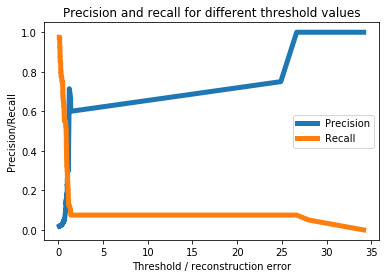

In [11]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['ATT_FLAG'] == 1})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold / reconstruction error')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## Evaluate on testing

based on the above plot, choose a fixed threshold when the reconstruction error is too large

Threshold:  0.0


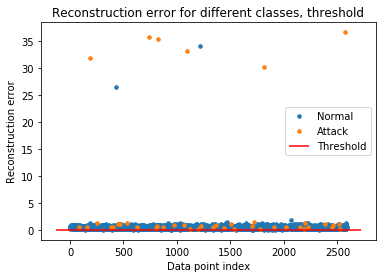


-----------------------------------
Threshold: 0.00
-----------------------------------
Accuracy: 1.93
Precision: 1.93
Recall: 100.00
F_score: 3.79
-----------------------------------

Threshold:  0.1


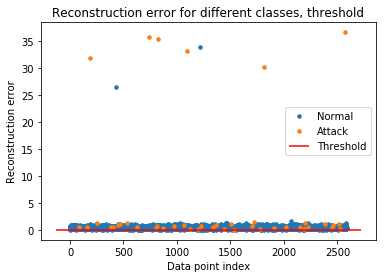


-----------------------------------
Threshold: 0.10
-----------------------------------
Accuracy: 4.25
Precision: 1.98
Recall: 100.00
F_score: 3.88
-----------------------------------

Threshold:  0.2


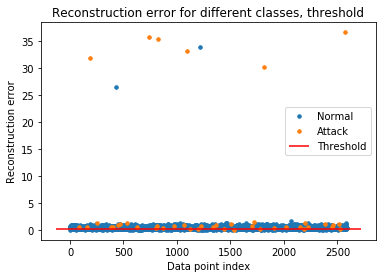


-----------------------------------
Threshold: 0.20
-----------------------------------
Accuracy: 15.22
Precision: 1.96
Recall: 87.50
F_score: 3.84
-----------------------------------

Threshold:  0.30000000000000004


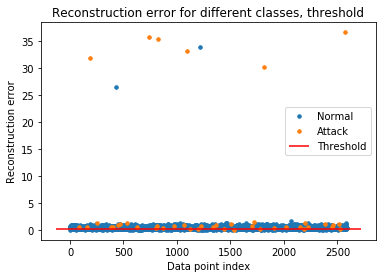


-----------------------------------
Threshold: 0.30
-----------------------------------
Accuracy: 33.24
Precision: 2.28
Recall: 80.00
F_score: 4.43
-----------------------------------

Threshold:  0.4


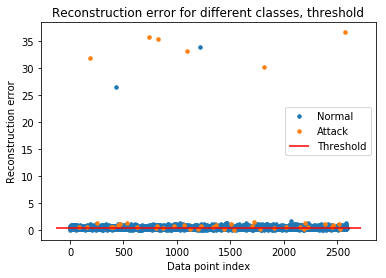


-----------------------------------
Threshold: 0.40
-----------------------------------
Accuracy: 43.43
Precision: 2.52
Recall: 75.00
F_score: 4.87
-----------------------------------

Threshold:  0.5


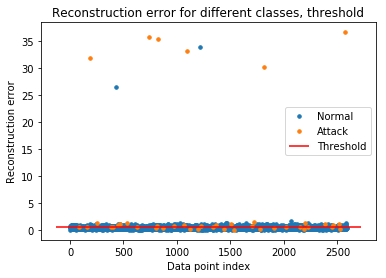


-----------------------------------
Threshold: 0.50
-----------------------------------
Accuracy: 59.66
Precision: 3.51
Recall: 75.00
F_score: 6.70
-----------------------------------

Threshold:  0.6000000000000001


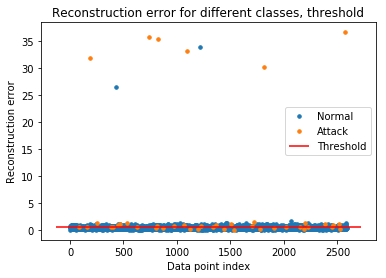


-----------------------------------
Threshold: 0.60
-----------------------------------
Accuracy: 71.59
Precision: 4.33
Recall: 65.00
F_score: 8.12
-----------------------------------

Threshold:  0.7000000000000001


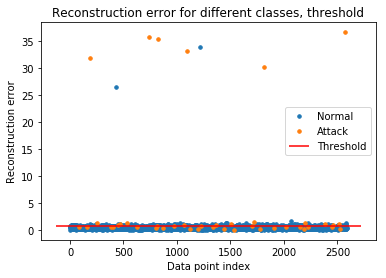


-----------------------------------
Threshold: 0.70
-----------------------------------
Accuracy: 80.43
Precision: 5.38
Recall: 55.00
F_score: 9.80
-----------------------------------

Threshold:  0.8


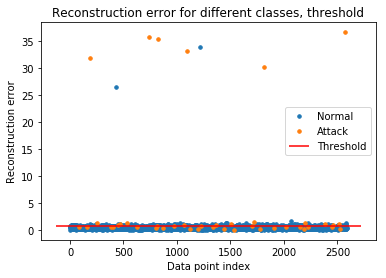


-----------------------------------
Threshold: 0.80
-----------------------------------
Accuracy: 88.16
Precision: 8.84
Recall: 55.00
F_score: 15.22
-----------------------------------

Threshold:  0.9


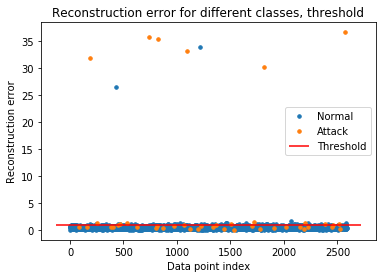


-----------------------------------
Threshold: 0.90
-----------------------------------
Accuracy: 93.72
Precision: 13.71
Recall: 42.50
F_score: 20.73
-----------------------------------

Threshold:  1.0


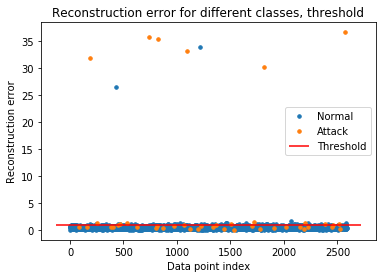


-----------------------------------
Threshold: 1.00
-----------------------------------
Accuracy: 96.28
Precision: 19.67
Recall: 30.00
F_score: 23.76
-----------------------------------

Threshold:  1.1


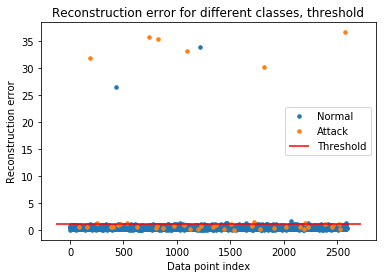


-----------------------------------
Threshold: 1.10
-----------------------------------
Accuracy: 97.68
Precision: 33.33
Recall: 20.00
F_score: 25.00
-----------------------------------

Threshold:  1.2000000000000002


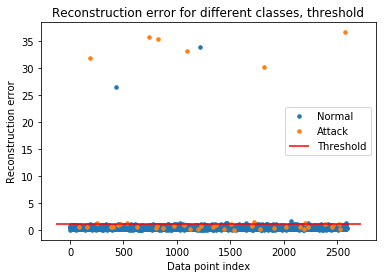


-----------------------------------
Threshold: 1.20
-----------------------------------
Accuracy: 98.12
Precision: 55.56
Recall: 12.50
F_score: 20.41
-----------------------------------

Threshold:  1.3


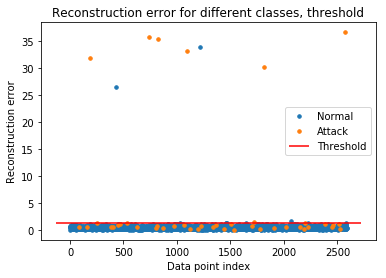


-----------------------------------
Threshold: 1.30
-----------------------------------
Accuracy: 98.21
Precision: 71.43
Recall: 12.50
F_score: 21.28
-----------------------------------

Threshold:  1.4000000000000001


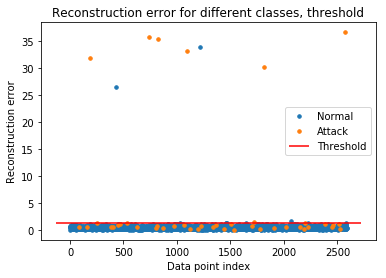


-----------------------------------
Threshold: 1.40
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  1.5


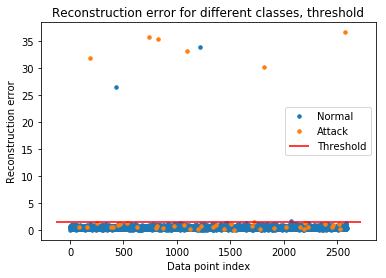


-----------------------------------
Threshold: 1.50
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  1.6


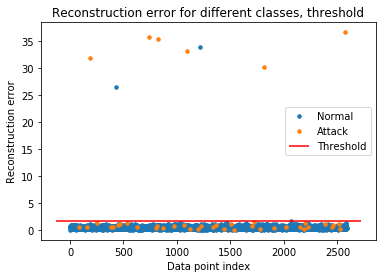


-----------------------------------
Threshold: 1.60
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  1.7000000000000002


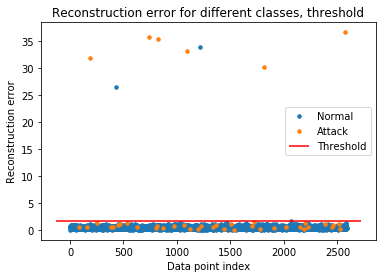


-----------------------------------
Threshold: 1.70
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  1.8


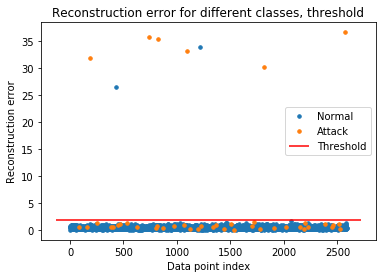


-----------------------------------
Threshold: 1.80
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  1.9000000000000001


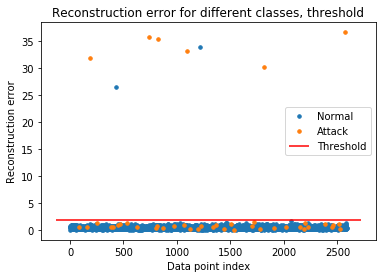


-----------------------------------
Threshold: 1.90
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  2.0


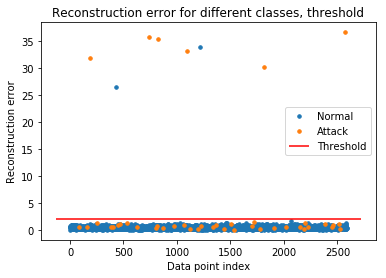


-----------------------------------
Threshold: 2.00
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  2.1


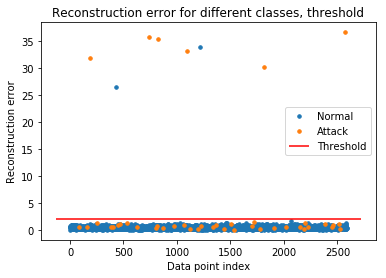


-----------------------------------
Threshold: 2.10
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  2.2


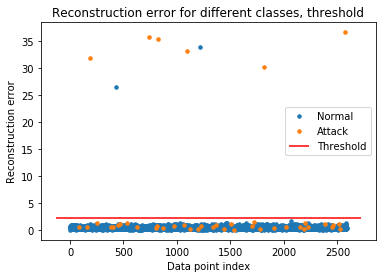


-----------------------------------
Threshold: 2.20
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  2.3000000000000003


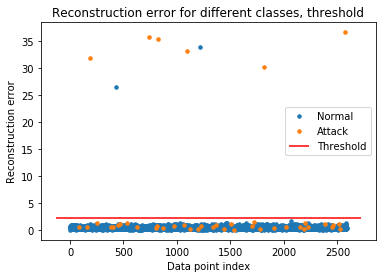


-----------------------------------
Threshold: 2.30
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  2.4000000000000004


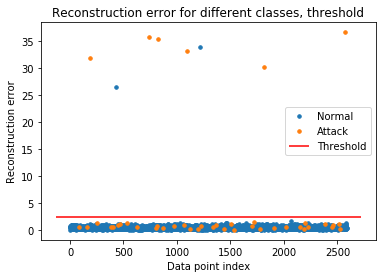


-----------------------------------
Threshold: 2.40
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  2.5


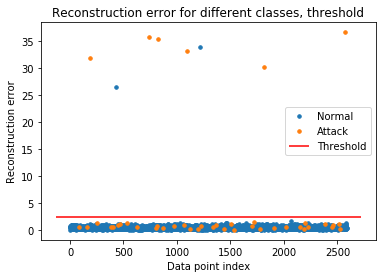


-----------------------------------
Threshold: 2.50
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  2.6


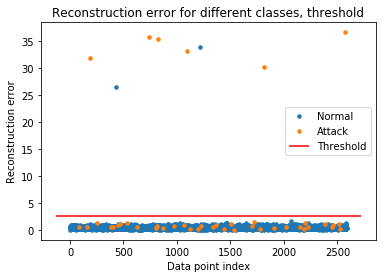


-----------------------------------
Threshold: 2.60
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  2.7


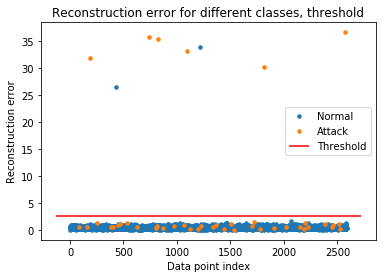


-----------------------------------
Threshold: 2.70
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  2.8000000000000003


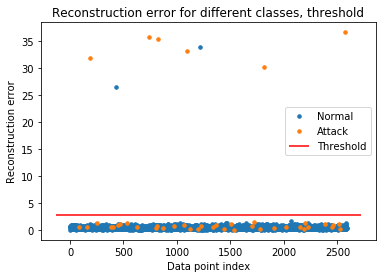


-----------------------------------
Threshold: 2.80
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------

Threshold:  2.9000000000000004


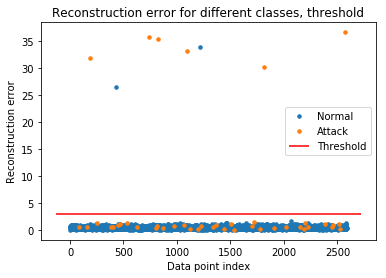


-----------------------------------
Threshold: 2.90
-----------------------------------
Accuracy: 98.12
Precision: 60.00
Recall: 7.50
F_score: 13.33
-----------------------------------



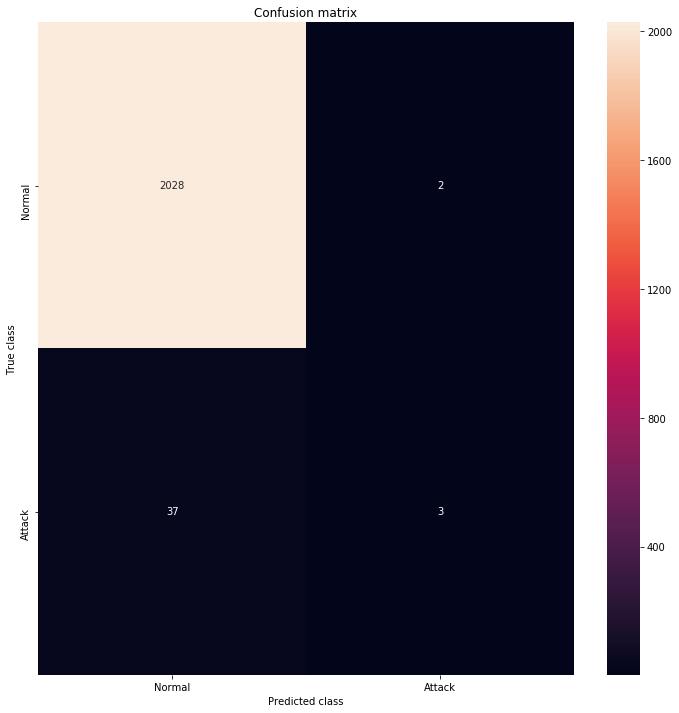

In [12]:
acc = 0
f_sc = 0
best_threshold_fixed = 0
for threshold_fixed in np.arange(0.0, 3.0, 0.1):

#threshold_fixed = 3.0

    test_x_predictions = autoencoder.predict(df_test_x_rescaled)
    mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
    error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                            'True_class': df_test['ATT_FLAG']})
    error_df_test = error_df_test.reset_index()

    groups = error_df_test.groupby('True_class')

    fig, ax = plt.subplots()

    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Attack" if name == 1 else "Normal")
    ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    print('Threshold: ', threshold_fixed)
    plt.title("Reconstruction error for different classes, threshold")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show();
    
    pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
    
    conf_matrix = confusion_matrix(error_df.True_class, pred_y)
    
    tn, fp, fn, tp = confusion_matrix(error_df.True_class, pred_y).ravel()
    Accuracy=(tp+tn)/(tp+tn+fp+fn)*100
    Precision=tp / (tp + fp)*100
    Recall = tp / (tp + fn)*100
    F_score = 2*tp /(2*tp + fp + fn)*100
    print("\n-----------------------------------")
    print("Threshold:","%.2f" % threshold_fixed)
    print("-----------------------------------")
    print("Accuracy:","%.2f" % Accuracy)
    print("Precision:","%.2f" % Precision)
    print("Recall:", "%.2f" %Recall)
    print("F_score:","%.2f" % F_score)
    print("-----------------------------------\n")

    
    if F_score > f_sc:
        best_conf_matrix = conf_matrix
        acc = Accuracy
        F_score = f_sc
        best_threshold_fixed = threshold_fixed
    
    plt.figure(figsize=(12, 12))
    sns.heatmap(best_conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

### Use autoencoder to predict outliers

Predict *attack* label if reconstruction error larger than the chosen threshold

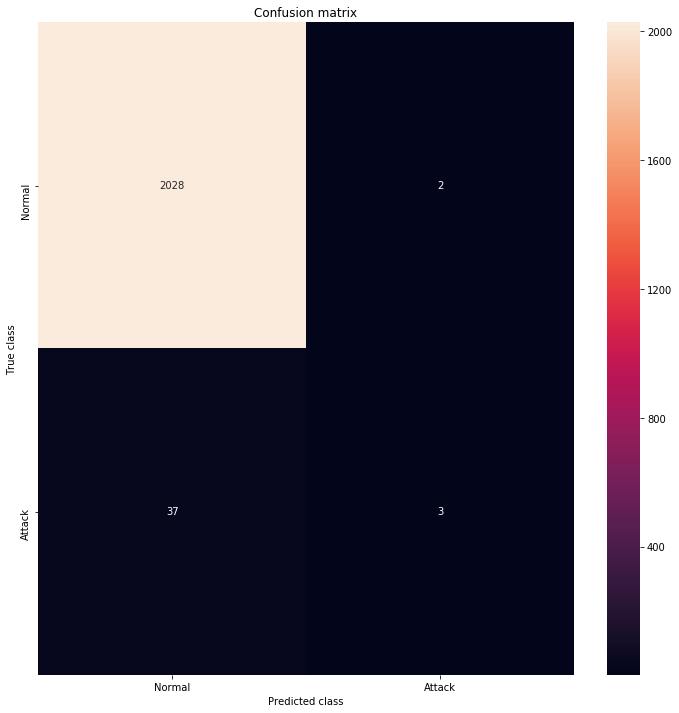

In [13]:
pred_y = [1 if e > best_threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Plot the ROC curve for the chosen threshold

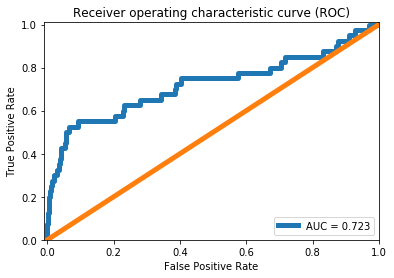

In [14]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()